## Dimensionality Reduction and Clustering

Let's use these metrics to perform dimensionality reduction (PCA, UMAP) and clustering (HDBSCAN) to explore underlying structure in the data.
We will try to cluster neurons from Secondary Motor Area, Layer 5 using morphological features.
First let's define functions for loading neuron graphs from specific CCF regions

In [1]:
#imports
from utils.graph_utils import *
from utils.plot_utils import *
from utils.clustering_utils import *
from utils.morphology_utils import *

In [2]:
import pandas as pd

# Load the CCF structure data as a DataFrame
ccf_structures = pd.read_csv('/data/allen_mouse_ccf/annotation/adult_mouse_ccf_structures.csv')
ccf_structures.head()
# Create a dictionary mapping region acronym to allen ID, since
# it is easier to remember acronyms like 'MOs5'



,id,name,acronym,hemisphere_id,parent_structure_id,graph_order,structure_id_path,color_hex_triplet
0,1000,extrapyramidal fiber systems,eps,3,1009.0,1218,/997/1009/1000/,CCCCCC
1,223,Arcuate hypothalamic nucleus,ARH,3,157.0,733,/997/8/343/1129/1097/157/223/,FF5D50
2,12998,"Somatosensory areas, layer 6b",SS6b,3,453.0,36,/997/8/567/688/695/315/453/12998/,188064
3,163,"Agranular insular area, posterior part, layer 2/3",AIp2/3,3,111.0,287,/997/8/567/688/695/315/95/111/163/,219866
4,552,"Pontine reticular nucleus, ventral part",PRNv,3,987.0,914,/997/8/343/1065/771/987/552/,FFBA86


In [3]:
acronym_to_id = ccf_structures.set_index('acronym')['id'].to_dict()
# Show the first 5 key-value pairs
list(acronym_to_id.items())[:5]

[('eps', 1000), ('ARH', 223), ('SS6b', 12998), ('AIp2/3', 163), ('PRNv', 552)]

In [4]:
#Note: Need to run the "create_manifest" notebook before this.
manifest_path = "../scratch/reconstructed_neurons.csv"
paths, acronyms = get_cells_in_regions(manifest_path, ['MOs5'])
graphs = load_graphs(paths)

100%|██████████| 163/163 [00:18<00:00,  8.61it/s]


Let's plot a random subset of neurons from MOs5 to see if we can identify any obvious morphological patterns

In [6]:
random.seed(47)

plot = k3d.plot()
plot_graphs(random.sample(graphs, 10), plot)
plot_ccf_mesh(acronym_to_id['root'], plot, color=rgb_to_hex(128,128,128), opacity=0.05)
plot_ccf_mesh(acronym_to_id['MOs5'], plot, color=rgb_to_hex(0, 255, 0), opacity=0.05)
plot.display()

Output()

Using the intuition gained from looking at the 3D structure of the neurons, think about what kinds of metrics could be used to differentiate cell groups based on their morphological properties.
For simplicity, let's use the metrics we have defined earlier, and extract them into an `m x n` array, where `m == num neurons` and `n == num features`

In [7]:
X = all_graph_metrics(graphs)

100%|██████████| 163/163 [00:14<00:00, 10.89it/s]


In [8]:
print(X)

     num_branch_points  num_terminals   total_length  mean_branch_length  \
0                  179            180   97363.793666          271.965904   
1                  371            381   92080.335643          122.610300   
2                  392            394  171392.923314          218.057154   
3                   99            108   57824.578432          280.701837   
4                  279            287   56859.558347          100.636386   
..                 ...            ...            ...                 ...   
158                322            329   45738.717191           70.367257   
159                645            655  460744.080939          354.691363   
160                259            266   43251.456852           82.540948   
161                257            264  105782.825097          203.428510   
162                191            199   87747.785675          225.572714   

     std_branch_length  max_branch_length  longest_path_length         depth  \
0      

## Correlation Matrix and Pair Plot to visualize relationships between features

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

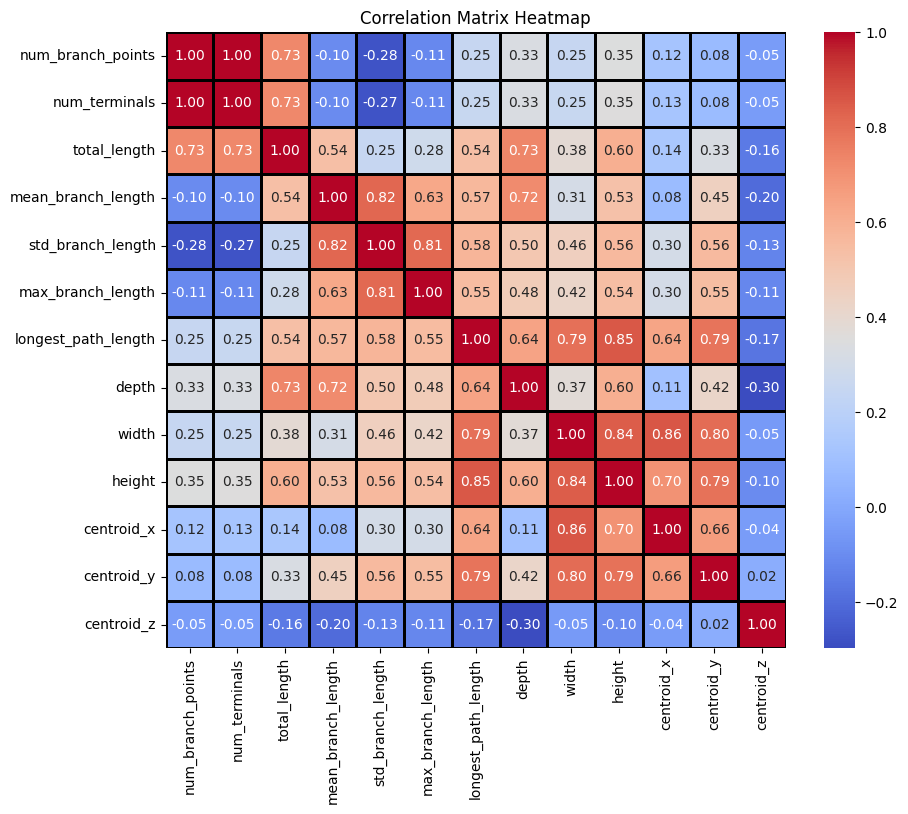

In [9]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2, linecolor='black')
plt.title('Correlation Matrix Heatmap')

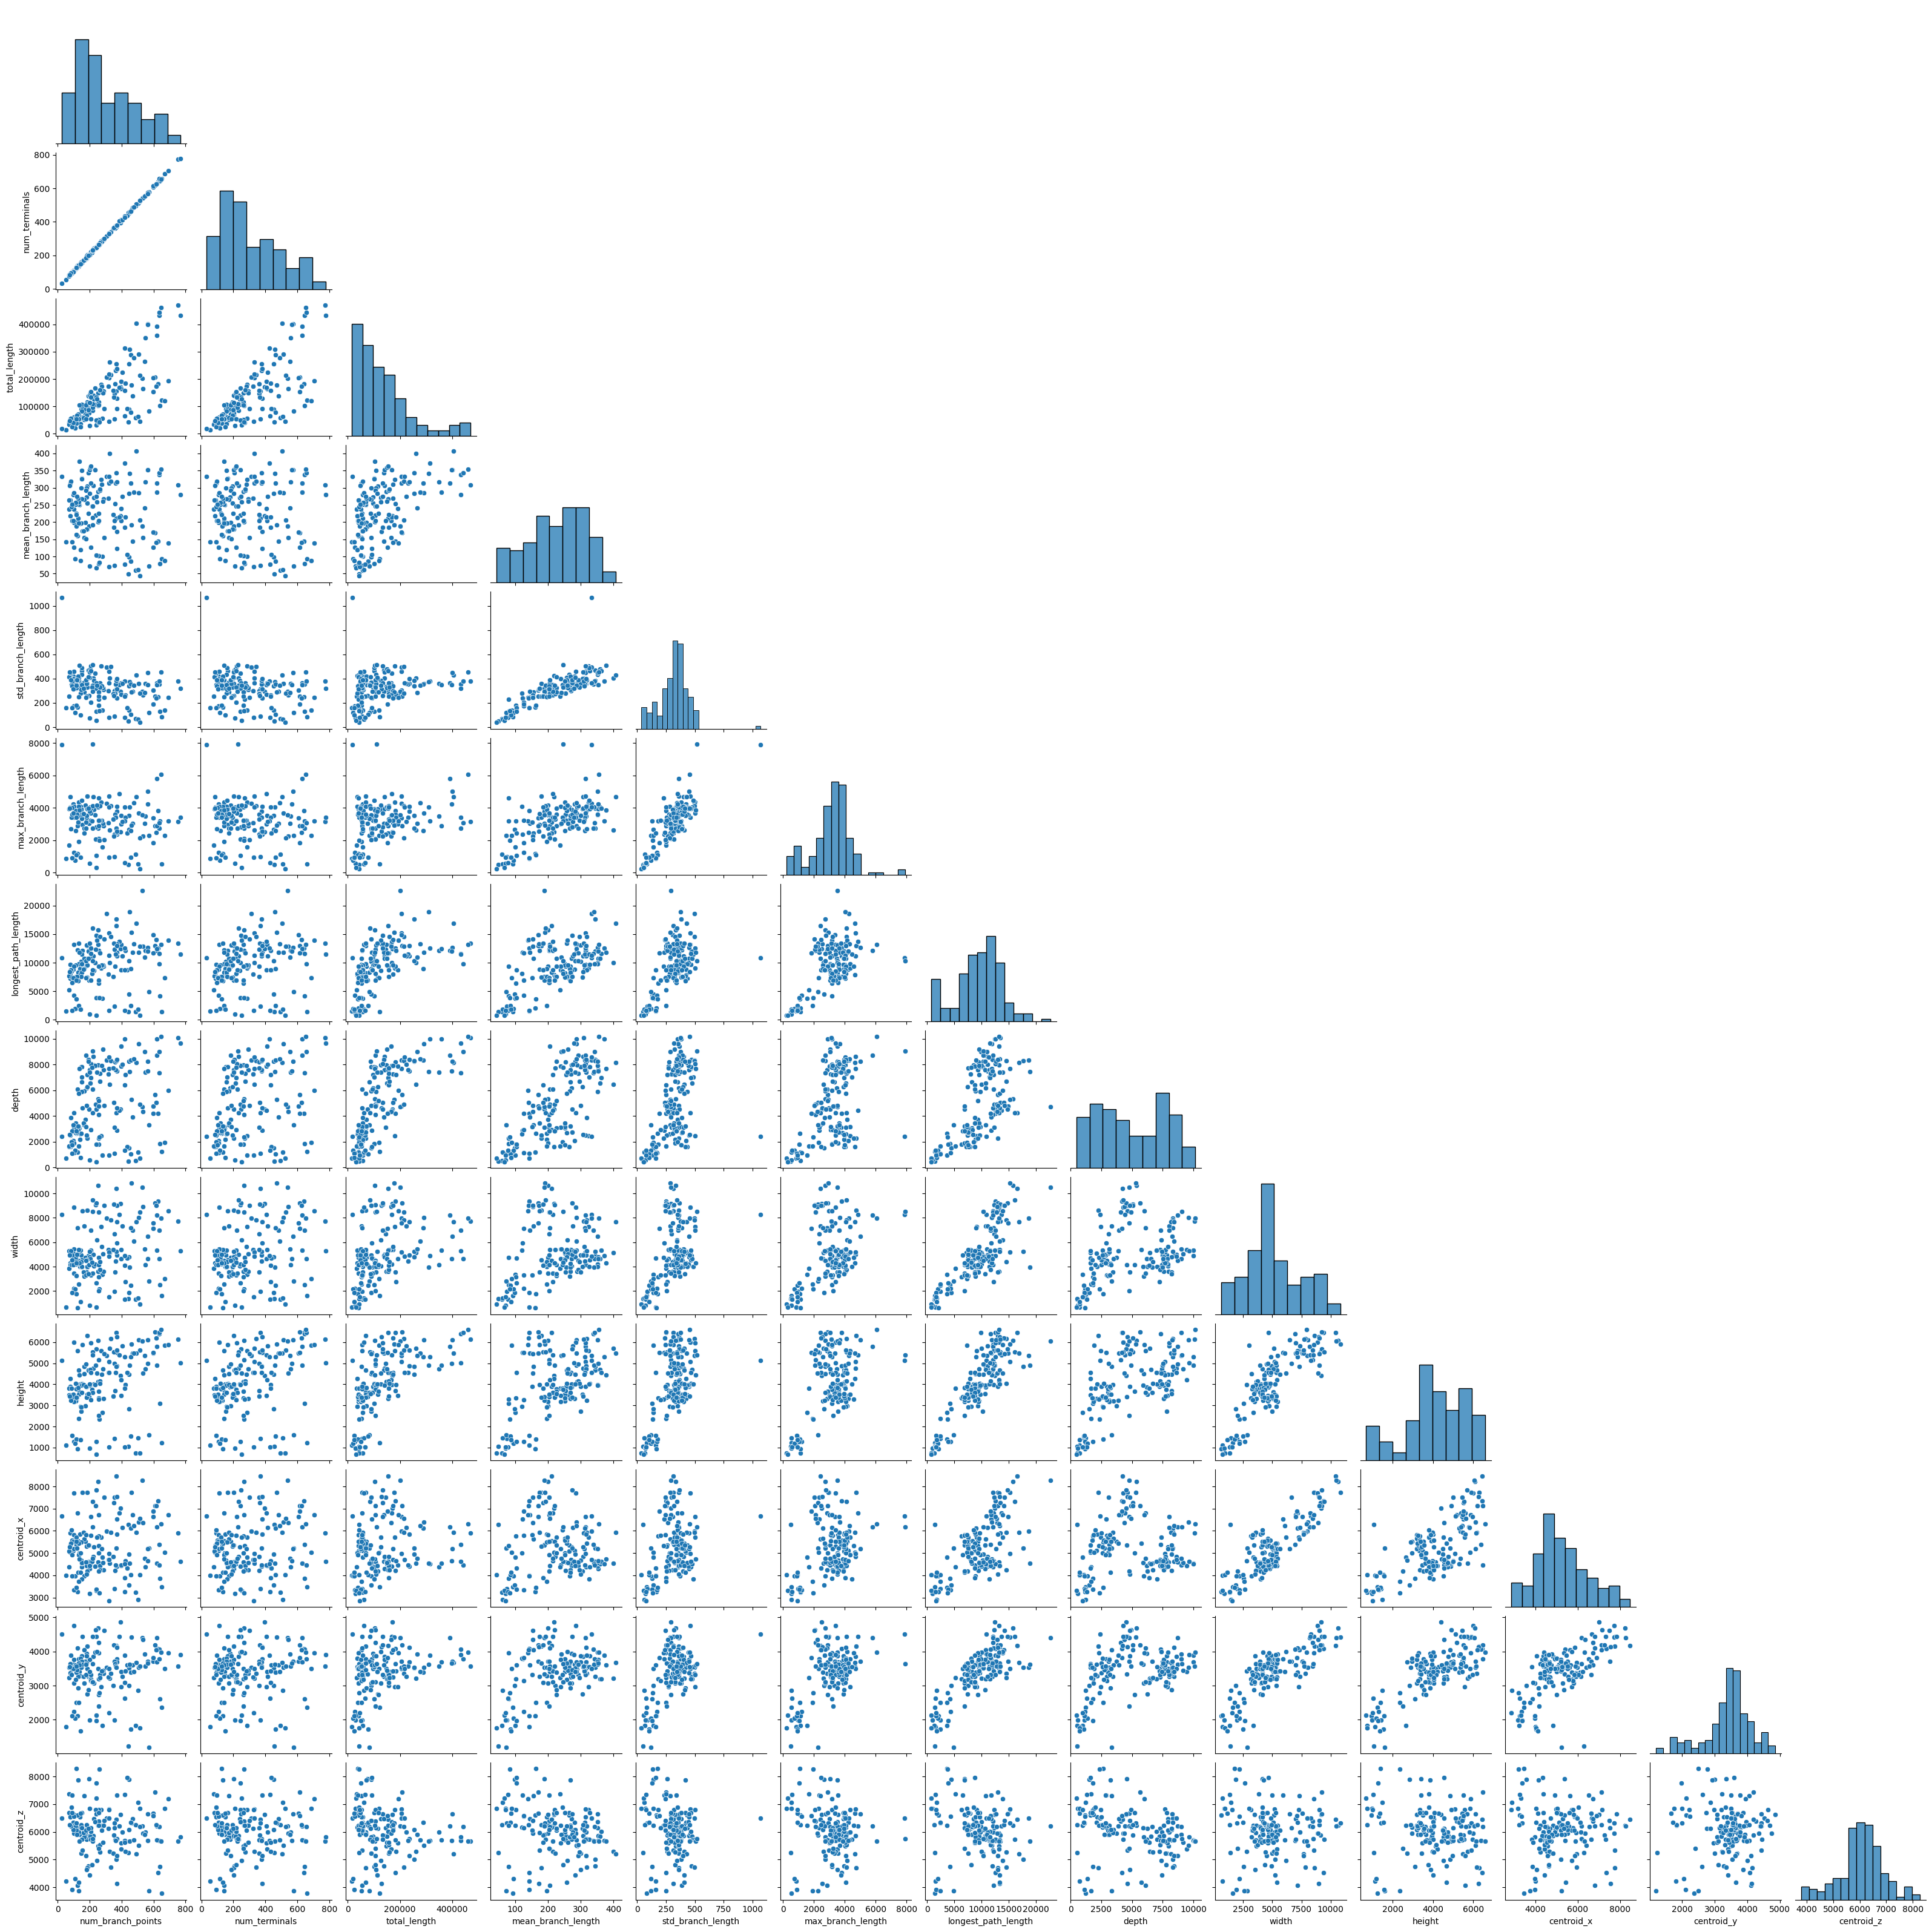

In [10]:

sns.pairplot(X, corner=True)

In [11]:
# Remove perfectly correlated feature
X = X.drop(columns=['num_terminals'])

In [12]:
from sklearn.preprocessing import StandardScaler

# remove mean and scale to unit variance
X = StandardScaler().fit_transform(X)
print(X)

[[-0.66414979 -0.3569024   0.51336175 ... -0.67666493  0.74092218
  -0.35510219]
 [ 0.42078767 -0.40898235 -1.20131223 ...  1.04556529  0.51985446
   1.50147906]
 [ 0.5394527   0.37281535 -0.10553656 ...  1.44181529  2.04749201
   0.68036731]
 ...
 [-0.21209252 -0.89029693 -1.66132762 ... -1.68351652 -0.8948913
   2.59438842]
 [-0.22339395 -0.27391457 -0.27348042 ... -0.88377104 -1.44073493
  -0.7395111 ]
 [-0.5963412  -0.45168903 -0.01925433 ...  0.0803132  -0.76190046
   0.09690213]]


/tmp/ipykernel_6081/3036701009.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


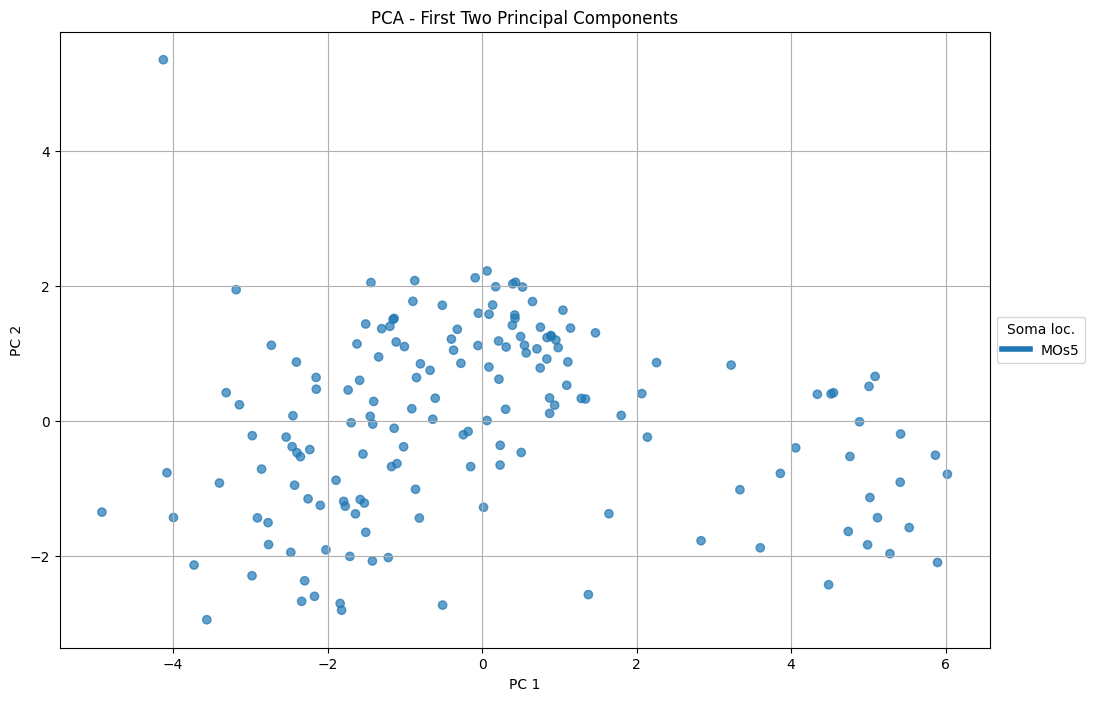

In [13]:
from sklearn.decomposition import PCA

def plot_pca(X, acronyms, n_components=2):
    p = PCA(n_components=n_components)
    transformed_data = p.fit_transform(X)

    # Map unique class labels to a range of integers
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Using a colormap that provides distinct colors
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    # Plotting the first two principal components
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title('PCA - First Two Principal Components')
    ax.grid(True)
    plt.show()

plot_pca(X, acronyms)

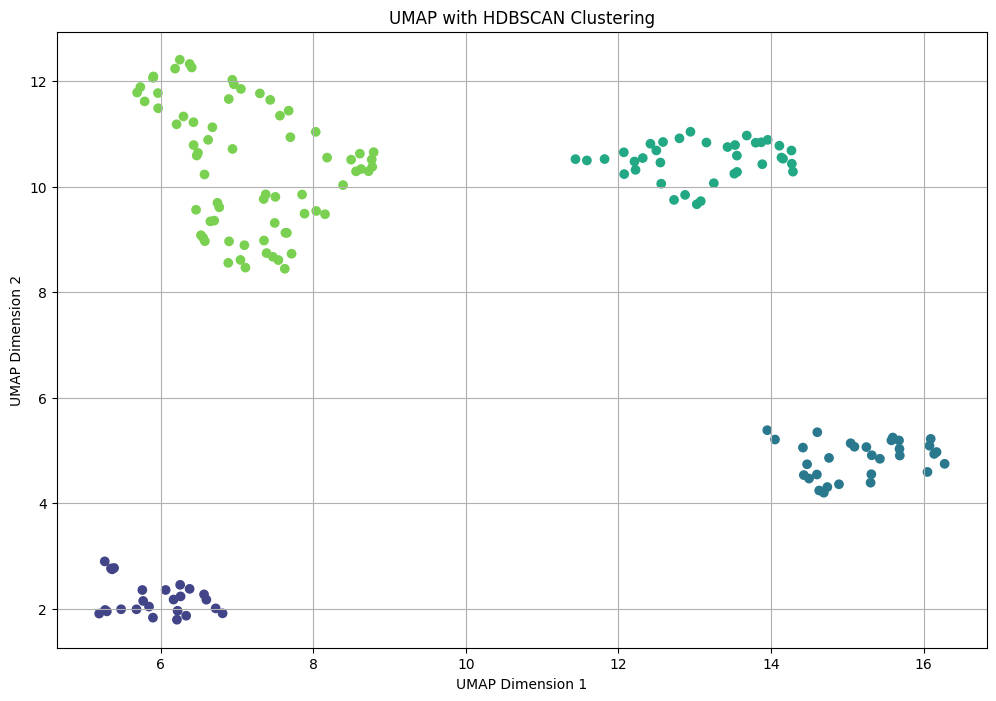

In [14]:
import umap
import hdbscan

def plot_umap(X, acronyms, n_neighbors=10, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # Map unique class labels to a range of integers for coloring
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")

    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title('UMAP')
    ax.grid(True)

    plt.show()


def plot_umap_with_hdbscan(X, acronyms, n_neighbors=10, min_dist=0.1, n_components=2, min_cluster_size=10):
    # UMAP Reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # HDBSCAN Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)  # Adjust min_cluster_size as needed
    clusters = clusterer.fit_predict(embedding)

    # Create a color palette with as many colors as there are unique clusters
    unique_clusters = np.unique(clusters)
    palette = sns.color_palette('viridis', len(unique_clusters))
    color_map = dict(zip(unique_clusters, palette))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=[color_map[x] for x in clusters])
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title('UMAP with HDBSCAN Clustering')
    ax.grid(True)

    plt.show()

    return clusters


cluster_labels = plot_umap_with_hdbscan(X, acronyms)

In [14]:
# Create a dictionary to hold graphs for each cluster
clusters = {}

# Iterate and group graphs by their cluster
for label, obj in zip(cluster_labels, graphs):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(obj)

In [15]:
for cluster in clusters.values():
    plot = k3d.plot()
    plot_graphs(cluster, plot)
    plot_ccf_mesh(acronym_to_id['root'], plot, color=rgb_to_hex(128,128,128), opacity=0.05)
    plot_ccf_mesh(acronym_to_id['MOs5'], plot, color=rgb_to_hex(0, 255, 0), opacity=0.05)
    plot.display()

/opt/conda/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

Output()

Output()

Output()

## Potential questions to consider
- Do the clusters have shared projection targets? How can we find out?
- Do we get different results if computing metrics on axons and dendrites separately, then combining during clustering?
- What other metrics could be useful? How would you calculate them?
- How can we integrate brain region information into clustering?
- Do these clusters correspond to known projection classes in MOs5?